# Data Preperation for Band Contrast dataset masks through the use of SAM
---

# Mount Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import dependencies


In [ ]:
# Tested on python 3.9.16
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

import cv2

import sys
sys.path.append("..")

import glob
from glob import glob
from natsort import natsorted

import numpy as np
import matplotlib.pyplot as plt
import random

import requests
import os
from skimage import io, color, img_as_ubyte
from skimage import exposure, img_as_float
from skimage.color import rgb2gray
from skimage.io import imread

PyTorch version: 2.1.0+cu118
Torchvision version: 0.16.0+cu118
CUDA is available: True


# This section defines the directory mapping
- **IMPORTATNT NOTE:** If your data is in a different directory structure update it in `dir_map`
---

In [ ]:
import os

dir_map = {
    'BC_IMAGES_DIR':'/content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/mydata/train/SAM_images',
    'BC_MASKS_OUTPUT_DIR':'/content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/mydata/train/SAM_masks',
    'BC_original_Image':'/content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/DataCollection/BC_Raw_Image',
}

# Used Primarily for Output Directory (Preferably not made yet), Raw Images folders need to have images to process
for _, path in dir_map.items():
    dir = os.getcwd() + '/' + path
    if not os.path.exists(dir):
        os.makedirs(dir)
        print(f'Directory "{str(dir)}" created')
    else:
        print(f'Directory "{str(dir)}" already exists')

Directory "/content//content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/mydata/train/SAM_images" created
Directory "/content//content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/mydata/train/SAM_masks" created
Directory "/content//content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/DataCollection/BC_Raw_Image" created


# Import Full Band Contrast image and apply preprocessing


In [ ]:
original_BC_path = dir_map['BC_original_Image'] + '/band_image.tif'
original_img = io.imread(original_BC_path)

In [ ]:
# Convert the image to float
img_float = img_as_float(original_img)

# Perform histogram equalization
equalized_img = exposure.equalize_hist(img_float)

# Apply additional contrast enhancement
contrast_img = exposure.rescale_intensity(equalized_img)

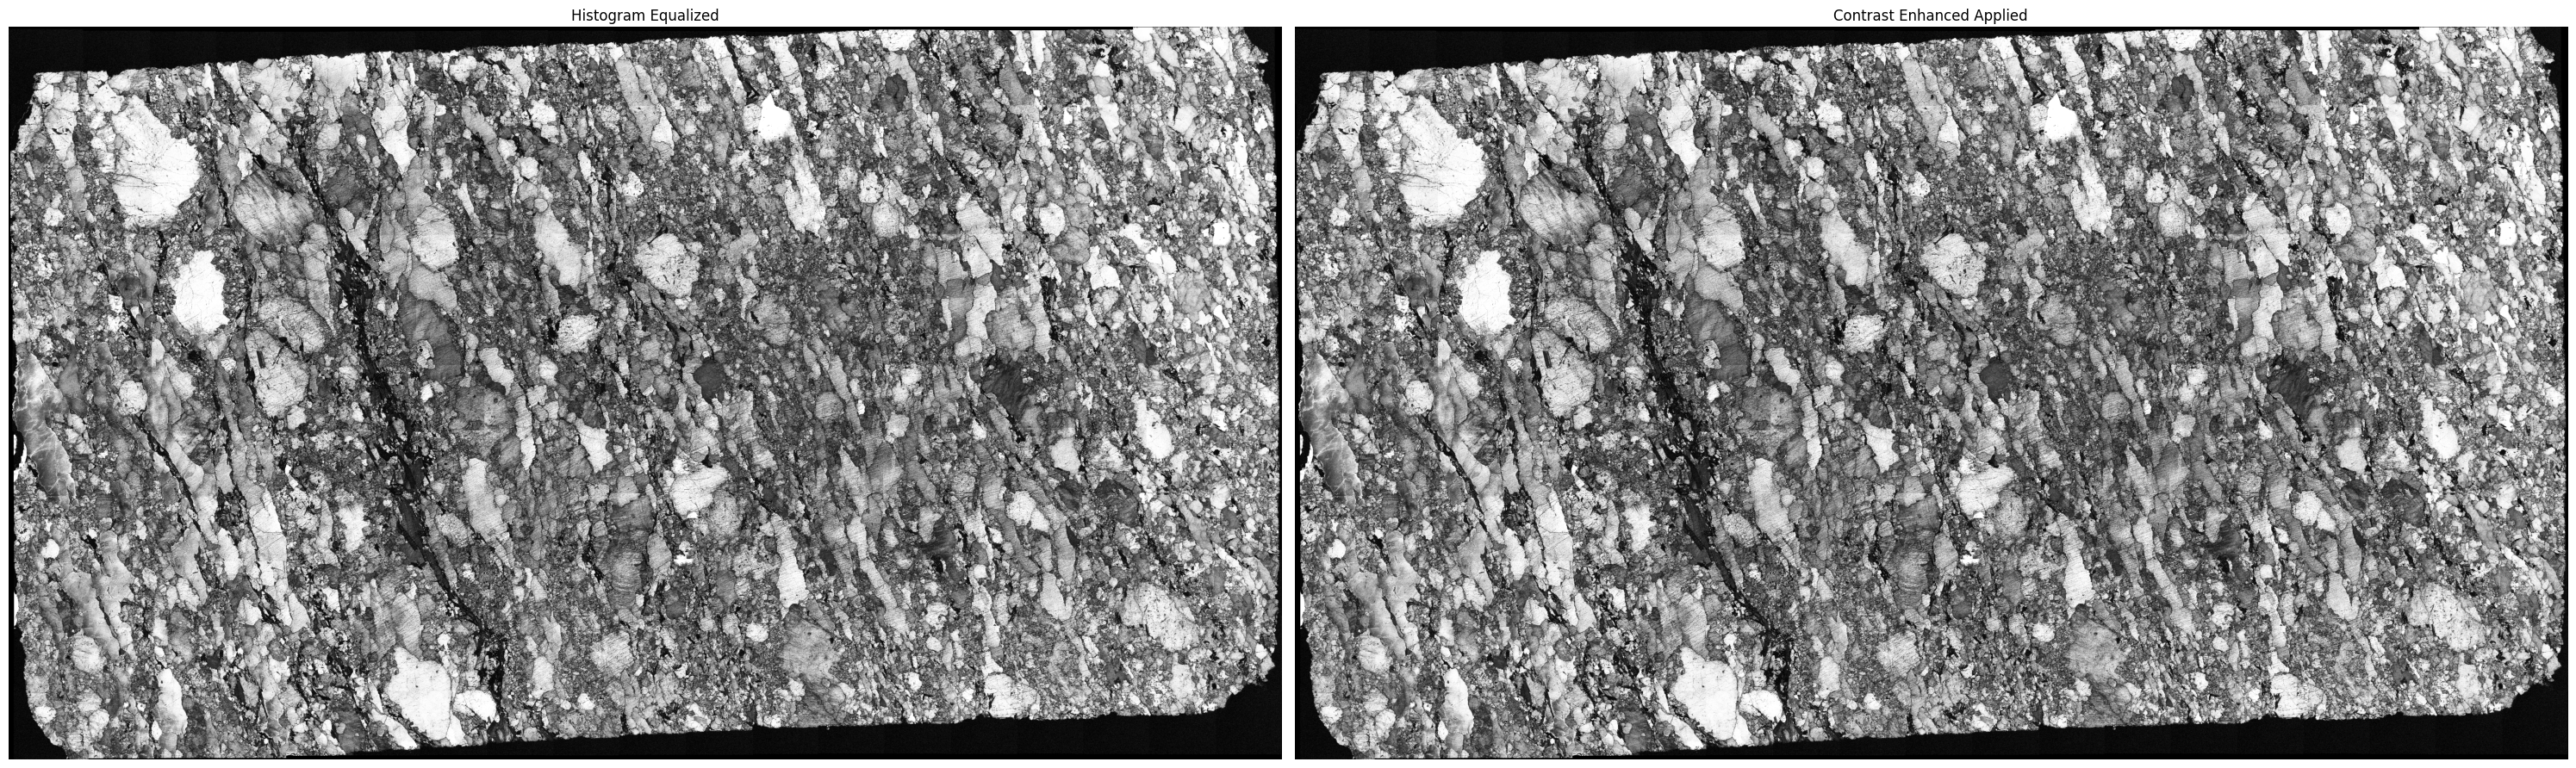

In [ ]:
# Display the images
fig, axes = plt.subplots(1, 2, figsize=(30, 30))
ax = axes.ravel()

ax[0].imshow(equalized_img, cmap=plt.cm.gray)
ax[0].set_title("Histogram Equalized")

ax[1].imshow(contrast_img, cmap=plt.cm.gray)
ax[1].set_title("Contrast Enhanced Applied")

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

# Define 100 x 100 for cropped images (This is variable)
- Have tried multiple image dimensions for testing and have found results to be better, as imaginable, when working with smaller dimensioned images for segmentation.

In [ ]:
# Define the size of the crops
crop_size = (100, 100)

# Calculate the number of crops that fit into the images
original_height, original_width = original_img.shape[:2]
n_crops_width = original_width // crop_size[0]
n_crops_height = original_height // crop_size[1]

# Print their values to see what we workin with lol
print("original_height:", original_height)
print("original_width:", original_width)
print("n_crops_width:", n_crops_width)
print("n_crops_height:", n_crops_height)

# Calculate the total number of 256x256 crops from the image
total_crops = n_crops_width * n_crops_height
print("\nTotal number of cropped images:", total_crops)


original_height: 2028
original_width: 3523
n_crops_width: 35
n_crops_height: 20

Total number of cropped images: 700


# Take BC image and generate list of crops with numbers to match them
- **IMPORTANT NOTE:**
---
  - **Only Run if images havent been generated yet in your folder**
---
- The images corpped are using contrast enhancement image

In [ ]:
# Function to crop the image
def crop_images(original, num_width, num_height, size):
    crops = []
    for i in range(num_height):
        for j in range(num_width):
            # Calculate the starting and ending indices for the crop
            start_x = j * size[0]
            start_y = i * size[1]
            end_x = start_x + size[0]
            end_y = start_y + size[1]

            # Crop the original image to the same area using array slicing
            crop_original = original[start_y:end_y, start_x:end_x]

            # Append the crops to the list
            crops.append({
                'original': crop_original,
                'position': (i, j)
            })

    return crops

# Crop the images
crops = crop_images(contrast_img, n_crops_width, n_crops_height, crop_size)

# Save the cropped images to files
output_files = []
for i, crop in enumerate(crops):
    original_crop_path = f'/content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/mydata/train/SAM_images/BC_processed_{i}.tif'
    io.imsave(original_crop_path, crop['original'])
    output_files.append((original_crop_path))

# Return the paths of the first few cropped images for display
output_files[:3]  # Show paths of the first 3 cropped images

['/content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/mydata/train/SAM_images/BC_original_crop0.tif',
 '/content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/mydata/train/SAM_images/BC_original_crop1.tif',
 '/content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/mydata/train/SAM_images/BC_original_crop2.tif']

# Print some images from the outputed files

Data type of the image: float64


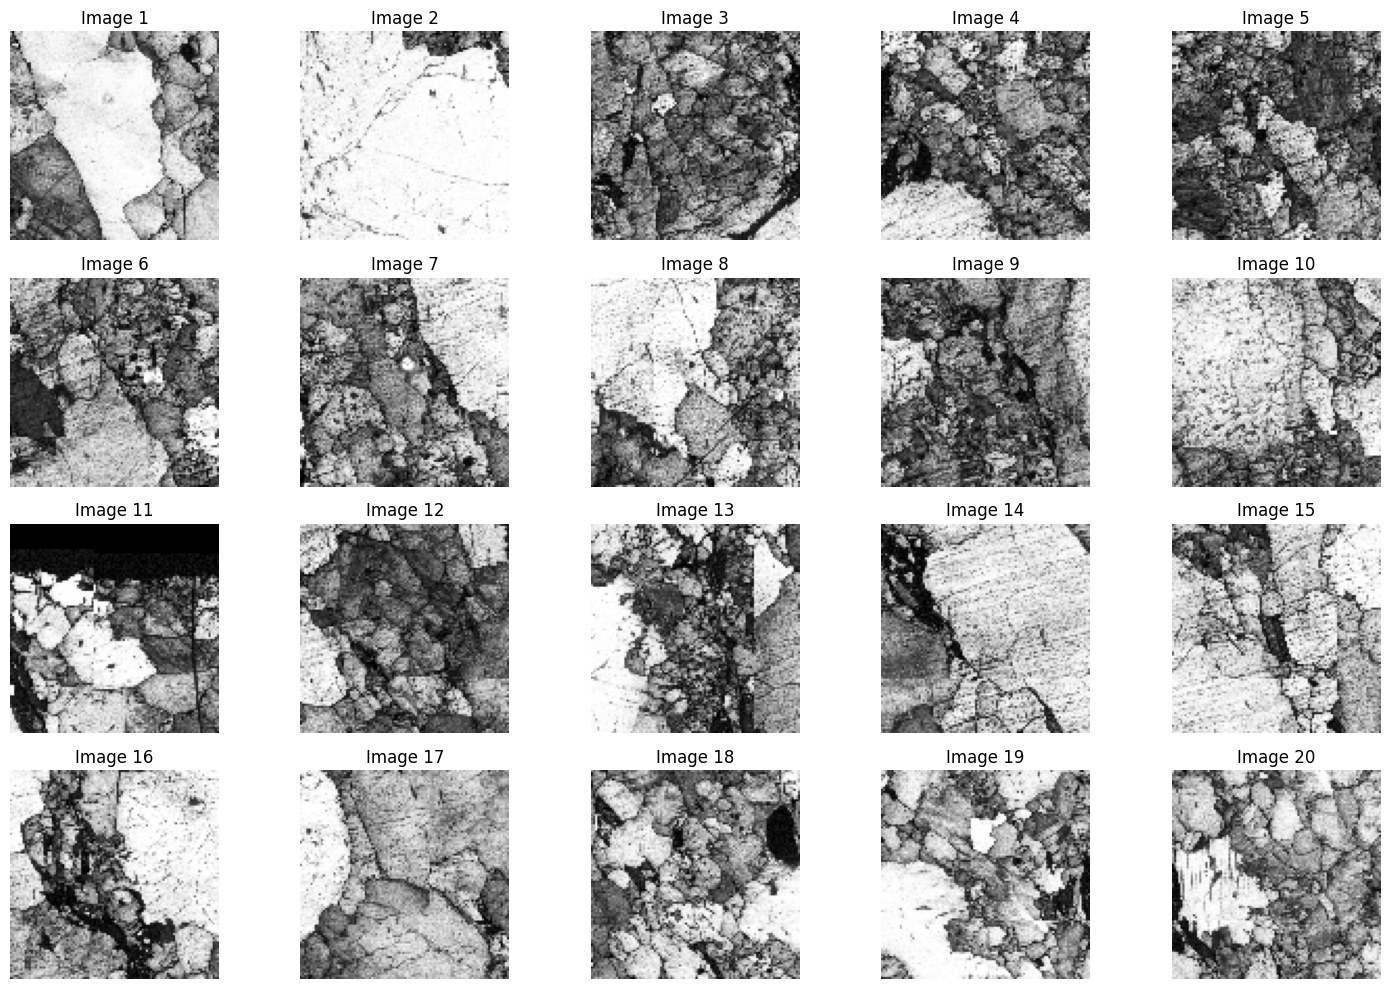

In [ ]:
# Use the directory path from dir_map
bc_images_dir = dir_map['BC_IMAGES_DIR']

# Get the list of image file paths
image_paths = glob.glob(os.path.join(bc_images_dir, '*.tif'))  # Adjust the file extension if needed
image_paths = sorted(image_paths)[:20]  # Sort and take the first 20 images

# Read the first image to check its data type
first_image = imread(image_paths[0])
print("Data type of the image:", first_image.dtype)

# Set up the matplotlib figure
plt.figure(figsize=(15, 10))  # Adjust the figure size as needed

# Loop through the first 20 image file paths and display them
for i, img_path in enumerate(image_paths):
    img = imread(img_path)  # Read the image
    plt.subplot(4, 5, i + 1)  # Adjust subplot grid as needed
    plt.imshow(img, cmap='gray')  # Adjust colormap if images are not grayscale
    plt.title(f'Image {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# This section sets the enviorment to use SAM to generate the masks
---
- **IMPORTANT NOTE: **
  - Install torch if not already. Do not run if already installed.
  - `!pip install torch torchvision`


In [ ]:
!pip install opencv-python matplotlib
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-acl2re2m
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-acl2re2m
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=699744f69a43ef5de1146f73f07f1d923ced468e48de34142c9052dc4f4f707f
  Stored in directory: /tmp/pip-ephem-wheel-cache-cgalq55a/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


# Download pretrained model

In [ ]:
# URL of the pretrained model
url = 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'

# Local path to save the downloaded model
file_path = 'sam_vit_h_4b8939.pth'

# Download the file from the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Open the file in write-binary mode and save the content
    with open(file_path, 'wb') as file:
        file.write(response.content)
    print(f"Model downloaded successfully and saved as {file_path}")
else:
    print("Failed to download the model")

Model downloaded successfully and saved as sam_vit_h_4b8939.pth


# Set downloaded model configs

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/content/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

# Define the function used to create the mask for the image

In [ ]:
'''
  Notes:
  Here are the description of the parameters
  #https://github.com/facebookresearch/segment-anything/blob/9e1eb9fdbc4bca4cd0d948b8ae7fe505d9f4ebc7/segment_anything/automatic_mask_generator.py#L35
'''

def generate_mask(img):
  mask_generator_ = SamAutomaticMaskGenerator(
      model=sam,
      points_per_side=64,
      pred_iou_thresh=0.90,
      stability_score_thresh=0.90,
      crop_n_layers=1,
      crop_n_points_downscale_factor=2,
      min_mask_region_area=100,  # Requires open-cv to run post-processing
      output_mode='binary_mask',
  )
  masks = mask_generator_.generate(img)
  return masks

# Define function to show annotations **(Needs to be reconfigured to be a binary version)**

In [ ]:
def show_anns(anns):
  if len(anns) == 0:
    return
  sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
  ax = plt.gca()
  ax.set_autoscale_on(False)
  polygons = []
  color = []
  for ann in sorted_anns:
    m = ann['segmentation']
    img = np.ones((m.shape[0], m.shape[1], 3))
    color_mask = np.random.random((1, 3)).tolist()[0]
    for i in range(3):
        img[:,:,i] = color_mask[i]
    ax.imshow(np.dstack((img, m*0.35)))

# Create Masks for all Band Contrast images
---
NOTE:
- This will overwrite the images present in your 'BC_MASKS_OUTPUT_DIR' whatever that may be
- This is the most computationaly intensive cell
- Requires GPU for CUDA pytorch

In [ ]:
"""
Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:

segmentation : the mask
area : the area of the mask in pixels
bbox : the boundary box of the mask in XYWH format
predicted_iou : the model's own prediction for the quality of the mask
point_coords : the sampled input point that generated this mask
stability_score : an additional measure of mask quality
crop_box : the crop of the image used to generate this mask in XYWH format
output_mode (str): The form masks are returned in. Can be 'binary_mask',

"""
# Process all images in BC_image_paths
BC_image_paths = natsorted(glob(dir_map['BC_IMAGES_DIR'] + '/*.tif'))

for idx, img_path in enumerate(BC_image_paths[:1]):
  # Load the current image
  BC_original_img = io.imread(img_path)

  # Convert grayscale image to RGB if necessary
  BC_original_img = color.gray2rgb(BC_original_img)

  # Convert to uint8
  BC_original_img = img_as_ubyte(BC_original_img)

  # Generate masks for the current image
  masks = generate_mask(BC_original_img)

  # Create an empty combined mask for the current image
  combined_mask = np.zeros_like(masks[0]['segmentation'], dtype=np.uint8)

  # Combine individual masks into the combined mask for the current image
  for mask_dict in masks:
    combined_mask += (mask_dict['segmentation']).astype(np.uint8)

  # Define the filename for the current mask, incrementing the index
  custom_name = f"BC_mask_{idx+1}.tif"  # Adding 30 because the loop starts from the 30th image

  # Specify the save path for the current mask
  save_path = os.path.join(dir_map['BC_MASKS_OUTPUT_DIR'], custom_name)

  # Save the combined mask to a file
  io.imsave(save_path, combined_mask)

  # Print a message indicating that the masks for the current image have been processed and saved
  print(f"BC mask -> {custom_name} has been processed and saved ")

<ipython-input-38-0f1317028715>:44: UserWarning: /content/drive/Shared drives/Grain Detection Project Trello/Ben/Grain Boundary Detection/Stardist/data/mydata/train/SAM_masks/BC_mask_1.tif is a low contrast image
  io.imsave(save_path, combined_mask)


BC mask -> BC_mask_1.tif has been processed and saved 


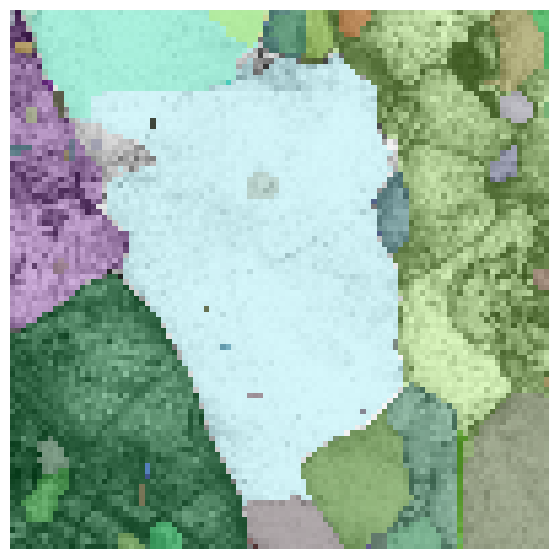

In [ ]:
plt.figure(figsize=(7,7))
plt.imshow(BC_original_img)
show_anns(masks)
plt.axis('off')
plt.show()

In [ ]:
# Process all images in BC_image_paths
BC_image_paths = natsorted(glob(dir_map['BC_IMAGES_DIR'] + '/*.tif'))

for idx, img_path in enumerate(BC_image_paths[:1]):
    # Load the current image
    BC_original_img = io.imread(img_path)

    # Convert grayscale image to RGB if necessary
    BC_original_img = color.gray2rgb(BC_original_img)

    # Convert to uint8
    BC_original_img = img_as_ubyte(BC_original_img)

    # Generate masks for the current image
    masks = generate_mask(BC_original_img)

    # Copy the original image to create an annotated version
    annotated_img = BC_original_img.copy()

    # Iterate over each mask and apply it to the annotated image
    for mask_dict in masks:
        mask = mask_dict['segmentation']
        annotated_img[mask > 0] = 255  # Setting mask areas to white

    # Define the filename for the annotated image, incrementing the index
    custom_name = f"BC_annotated_binary_{idx+1}.tif"

    # Specify the save path for the annotated image
    save_path = os.path.join(dir_map['BC_MASKS_OUTPUT_DIR'], custom_name)

    # Save the annotated image to a file
    io.imsave(save_path, annotated_img)

    # Print a message indicating that the annotated image has been processed and saved
    print(f"BC annotated binary image -> {custom_name} has been processed and saved")


# Plot image and call show_anns to display annotations found in image in color

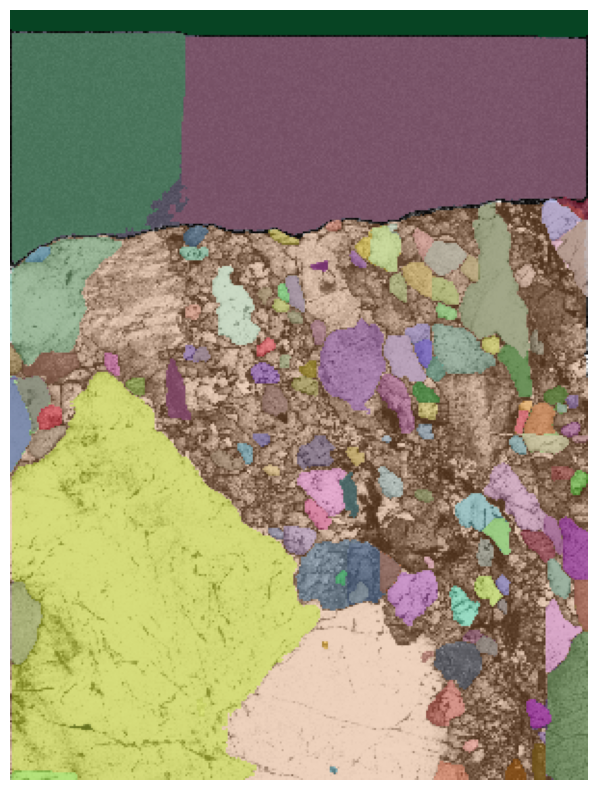

360000


In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(BC_original_img)
show_anns(masks)

plt.axis('off')
plt.show()

# Display last processed image and its corresponding mask

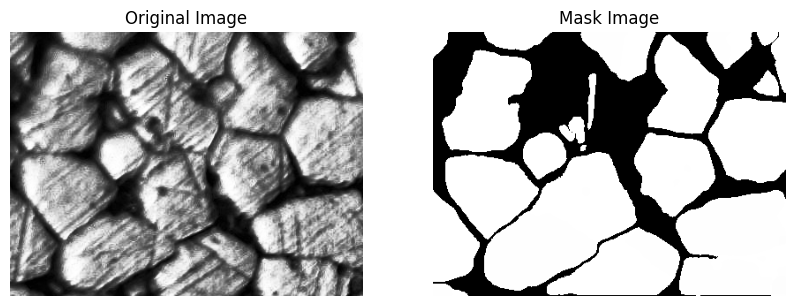

In [ ]:
# Function to display a pair of original and mask images
def mask_pair(img, mask):

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    # Display the original crop
    axes[0].imshow(img, cmap='gray')
    axes[0].axis('off')
    axes[0].set_title('Original Image')

    # Display the mask crop
    axes[1].imshow(mask, cmap='gray')
    axes[1].axis('off')
    axes[1].set_title('Mask Image')

    # Display the plot
    plt.show()

# Display a pair
mask_pair(BC_original_img, combined_mask)

# Display random pair of original cropped image and its corresponding mask

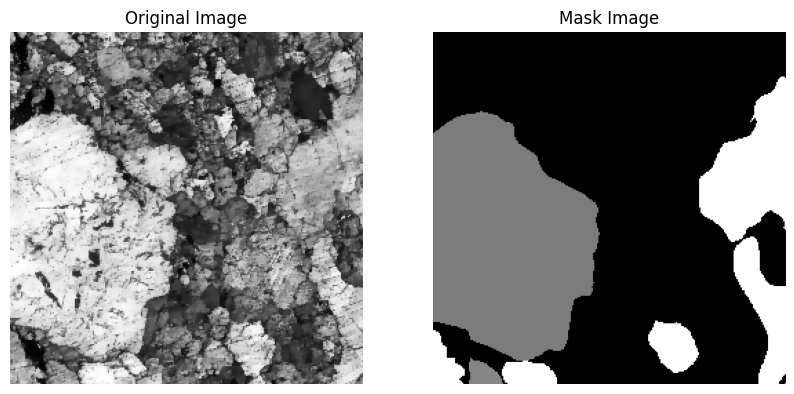

In [ ]:
# Function to display a random pair of original and mask images
def random_pair(crops):

    # Randomly select one set of crops
    selected_pair = random.choice(crops)
    original_crop = selected_pair['original']
    mask_crop = selected_pair['mask']

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    # Display the original crop
    axes[0].imshow(original_crop, cmap='gray')
    axes[0].axis('off')
    axes[0].set_title('Original Image')

    # Display the mask crop
    axes[1].imshow(mask_crop, cmap='gray')
    axes[1].axis('off')
    axes[1].set_title('Mask Image')

    # Display the plot
    plt.show()

# Display a random pair
random_pair(crops)
